In [172]:
#!pip install lightgbm

In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import *
import lightgbm
from lightgbm import LGBMClassifier
import joblib  #base package which is used to save the model

In [174]:
data=pd.read_csv("attrition.csv")

In [175]:
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [176]:
data['Attrition'] = np.where(data.Attrition=='Yes', 1, 0)

In [177]:
print("Duplicates:", data.duplicated().sum())
print("Missing values:", data.isna().sum().sum())
print("Single valued columns:", data.columns[data.nunique()==1])

Duplicates: 0
Missing values: 0
Single valued columns: Index(['EmployeeCount', 'Over18', 'StandardHours'], dtype='object')


In [178]:
# drop columns with only one value
data = data.drop(data.columns[data.nunique()==1], axis=1)

In [179]:
data.Attrition.value_counts(normalize=True)

0    0.838776
1    0.161224
Name: Attrition, dtype: float64

In [180]:
#separating X and Y
Y=data["Attrition"]
X=data.drop("Attrition",axis=1)

In [181]:
cats = X.columns[X.dtypes=='O'].tolist()
X[cats].head()

,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,OverTime
0,Travel_Rarely,Sales,Life Sciences,Female,Sales Executive,Single,Yes
1,Travel_Frequently,Research & Development,Life Sciences,Male,Research Scientist,Married,No
2,Travel_Rarely,Research & Development,Other,Male,Laboratory Technician,Single,Yes
3,Travel_Frequently,Research & Development,Life Sciences,Female,Research Scientist,Married,Yes
4,Travel_Rarely,Research & Development,Medical,Male,Laboratory Technician,Married,No


In [182]:
X0, X1, Y0, Y1 = train_test_split(X, Y, test_size=0.25, random_state=42)

In [183]:
for i in cats:
    le=LabelEncoder()
    le.fit(X0[i])
    X0[i] = le.transform(X0[i])
    X1[i] = le.transform(X1[i])
    X[i] = le.transform(X[i])

<ipython-input-183-ee983a5318ce>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X0[i] = le.transform(X0[i])
<ipython-input-183-ee983a5318ce>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X1[i] = le.transform(X1[i])


### Gradient Boosting with lightgbm

In [184]:
lgbm = LGBMClassifier(boosting_type= 'gbdt',objective = 'binary',
                     max_depth = 5,learning_rate = 0.005,
                     n_estimators = 200,class_weight ='balanced',
                     reg_alpha = 10,reg_lambda = 1,
                     random_state=42,n_jobs=-1)
lgbm.fit(X0,Y0,categorical_feature = cats,eval_set = (X1,Y1),eval_metric = 'auc')

/Users/zaranavasardyan/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/zaranavasardyan/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
/Users/zaranavasardyan/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/zaranavasardyan/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's auc: 0.681022	valid_0's binary_logloss: 0.692072
[2]	valid_0's auc: 0.681022	valid_0's binary_logloss: 0.691006
[3]	valid_0's auc: 0.681022	valid_0's binary_logloss: 0.689951
[4]	valid_0's auc: 0.681022	valid_0's binary_logloss: 0.688906
[5]	valid_0's auc: 0.681022	valid_0's binary_logloss: 0.687871
[6]	valid_0's auc: 0.681999	valid_0's binary_logloss: 0.686837
[7]	valid_0's auc: 0.681999	valid_0's binary_logloss: 0.685812
[8]	valid_0's auc: 0.681999	valid_0's binary_logloss: 0.684806
[9]	valid_0's auc: 0.681999	valid_0's binary_logloss: 0.6838
[10]	valid_0's auc: 0.688314	valid_0's binary_logloss: 0.68284
[11]	valid_0's auc: 0.688314	valid_0's binary_logloss: 0.68186
[12]	valid_0's auc: 0.684147	valid_0's binary_logloss: 0.680915
[13]	valid_0's auc: 0.684408	valid_0's binary_logloss: 0.679941
[14]	valid_0's auc: 0.682975	valid_0's binary_logloss: 0.679012
[15]	valid_0's auc: 0.682975	valid_0's binary_logloss: 0.678063
[16]	valid_0's auc: 0.684538	valid_0's binary_logloss

LGBMClassifier(class_weight='balanced', learning_rate=0.005, max_depth=5,
               n_estimators=200, objective='binary', random_state=42,
               reg_alpha=10, reg_lambda=1)

In [185]:
#for classification you should predict probabilities
Y0_pred=lgbm.predict_proba(X0)[:,1]
Y1_pred=lgbm.predict_proba(X1)[:,1]

In [186]:
print("ROC_AUC Train:", roc_auc_score(Y0, Y0_pred))
print("ROC_AUC Test :", roc_auc_score(Y1, Y1_pred))

ROC_AUC Train: 0.8953997809419496
ROC_AUC Test : 0.7255533854166666


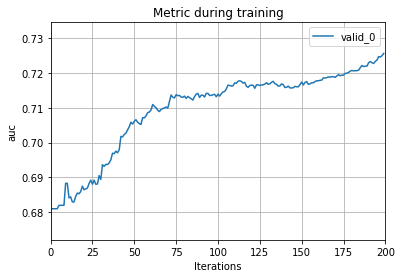

In [187]:
lightgbm.plot_metric(lgbm, metric='auc')

In [188]:
#Gridsearch can take some time

In [189]:
gridsearch_lgbm = GridSearchCV(LGBMClassifier(boosting_type = 'gbdt',objective='binary',
                               random_state=42,n_jobs=-1,class_weight = 'balanced'),
                          param_grid={'max_depth':range(3,6),'n_estimators': range(10,300,50), 
                                      'learning_rate': np.linspace(0.001,0.01, 5),
                                     'reg_alpha':np.linspace(0.5,2, 3),'reg_lambda':np.linspace(0.5,2, 3)},
                             
                          cv=5,scoring="roc_auc",n_jobs=-1).fit(X,Y,verbose=1)
best_lgbm = gridsearch_lgbm.best_params_
print(best_lgbm)

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 260, 'reg_alpha': 0.5, 'reg_lambda': 0.5}


In [197]:
lgbm_gs = LGBMClassifier(boosting_type = 'gbdt',objective='binary',
                      max_depth = best_lgbm['max_depth'],
                         learning_rate = best_lgbm['learning_rate'],
                     n_estimators = best_lgbm['max_depth'],
                         class_weight = 'balanced',
                     reg_alpha = best_lgbm['reg_alpha'],
                         reg_lambda = best_lgbm['reg_lambda'],
                         random_state=42,
                     n_jobs = -1)
lgbm_gs.fit(X0,Y0,categorical_feature = cats)

/Users/zaranavasardyan/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


LGBMClassifier(class_weight='balanced', learning_rate=0.01, max_depth=3,
               n_estimators=3, objective='binary', random_state=42,
               reg_alpha=0.5, reg_lambda=0.5)

In [198]:
#for classification you should predict probabilities
Y0_pred_gs=lgbm_gs.predict_proba(X0)[:,1]
Y1_pred_gs=lgbm_gs.predict_proba(X1)[:,1]

In [199]:
print("ROC_AUC Train:", roc_auc_score(Y0, Y0_pred_gs))
print("ROC_AUC Test :", roc_auc_score(Y1, Y1_pred_gs))

ROC_AUC Train: 0.7991330400968956
ROC_AUC Test : 0.6604166666666667


#### lighgbm plotting

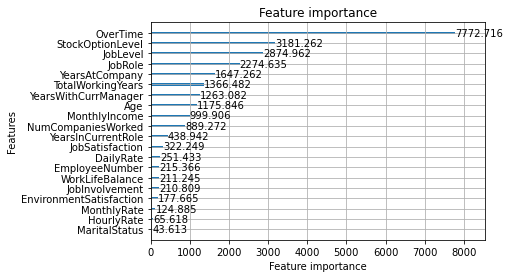

In [200]:
lightgbm.plot_importance(lgbm,importance_type='gain',max_num_features = 20)

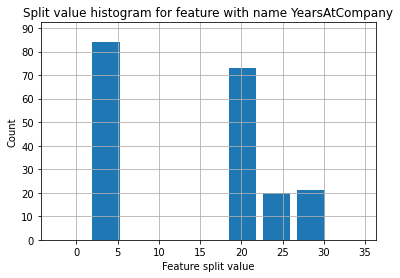

In [201]:
lightgbm.plot_split_value_histogram(lgbm,'YearsAtCompany')

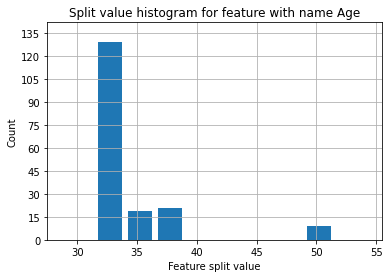

In [202]:
lightgbm.plot_split_value_histogram(lgbm,'Age')

### Random Forest with lightgbm

In [204]:
lgbm_rf = LGBMClassifier(boosting_type= 'rf',objective = 'binary',
                     max_depth = 5,learning_rate = 0.005,
                     n_estimators = 200,class_weight ='balanced',
                     reg_alpha = 10,reg_lambda = 1,bagging_freq=1,bagging_fraction=0.5,
                     random_state=42,n_jobs=-1)
lgbm_rf.fit(X0,Y0,categorical_feature = cats,eval_set = (X1,Y1),eval_metric = 'auc')

/Users/zaranavasardyan/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/zaranavasardyan/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
/Users/zaranavasardyan/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/zaranavasardyan/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[1]	valid_0's auc: 0.604948	valid_0's binary_logloss: 0.641786
[2]	valid_0's auc: 0.661165	valid_0's binary_logloss: 0.624499
[3]	valid_0's auc: 0.69668	valid_0's binary_logloss: 0.591968
[4]	valid_0's auc: 0.69248	valid_0's binary_logloss: 0.582756
[5]	valid_0's auc: 0.678027	valid_0's binary_logloss: 0.575467
[6]	valid_0's auc: 0.70026	valid_0's binary_logloss: 0.573227
[7]	valid_0's auc: 0.716081	valid_0's binary_logloss: 0.57174
[8]	valid_0's auc: 0.716146	valid_0's binary_logloss: 0.567391
[9]	valid_0's auc: 0.720736	valid_0's binary_logloss: 0.569105
[10]	valid_0's auc: 0.706608	valid_0's binary_logloss: 0.560801
[11]	valid_0's auc

[124]	valid_0's auc: 0.716341	valid_0's binary_logloss: 0.552477
[125]	valid_0's auc: 0.716602	valid_0's binary_logloss: 0.552958
[126]	valid_0's auc: 0.716927	valid_0's binary_logloss: 0.553138
[127]	valid_0's auc: 0.716081	valid_0's binary_logloss: 0.553033
[128]	valid_0's auc: 0.71582	valid_0's binary_logloss: 0.553326
[129]	valid_0's auc: 0.715365	valid_0's binary_logloss: 0.5533
[130]	valid_0's auc: 0.71543	valid_0's binary_logloss: 0.553233
[131]	valid_0's auc: 0.71556	valid_0's binary_logloss: 0.553027
[132]	valid_0's auc: 0.715365	valid_0's binary_logloss: 0.552896
[133]	valid_0's auc: 0.716211	valid_0's binary_logloss: 0.55261
[134]	valid_0's auc: 0.716081	valid_0's binary_logloss: 0.552536
[135]	valid_0's auc: 0.716146	valid_0's binary_logloss: 0.552446
[136]	valid_0's auc: 0.716276	valid_0's binary_logloss: 0.55269
[137]	valid_0's auc: 0.716536	valid_0's binary_logloss: 0.552774
[138]	valid_0's auc: 0.716732	valid_0's binary_logloss: 0.55296
[139]	valid_0's auc: 0.716862	val

LGBMClassifier(bagging_fraction=0.5, bagging_freq=1, boosting_type='rf',
               class_weight='balanced', learning_rate=0.005, max_depth=5,
               n_estimators=200, objective='binary', random_state=42,
               reg_alpha=10, reg_lambda=1)

In [205]:
#for classification you should predict probabilities
Y0_pred_rf=lgbm_rf.predict_proba(X0)[:,1]
Y1_pred_rf=lgbm_rf.predict_proba(X1)[:,1]

In [206]:
print("ROC_AUC Train:", roc_auc_score(Y0, Y0_pred_rf))
print("ROC_AUC Test :", roc_auc_score(Y1, Y1_pred_rf))

ROC_AUC Train: 0.8544365050389147
ROC_AUC Test : 0.7216796875000001


In [207]:
# Saving the model

In [208]:
joblib.dump(lgbm_rf,'model_lgbm_rf.dat')

['model_lgbm_rf.dat']

In [ ]:
#model = joblib.load('model_lgbm_rf.dat')
#model.get_params()
#model.feature_name_